# Forecasting with Chronos


AutoGluon-TimeSeries (AG-TS) includes [Chronos](https://github.com/amazon-science/chronos-forecasting) family of forecasting models. Chronos models are pretrained on a large collection of real & synthetic time series data, which enables them to make accurate forecasts on new data out of the box.

AG-TS provides a robust and easy way to use Chronos through the familiar `TimeSeriesPredictor` API. This tutorial describes how to
- Use Chronos models in **zero-shot** mode to make forecasts without any dataset-specific training
- **Fine-tune** Chronos models on custom data to improve the accuracy
- Handle **covariates & static features** by combining Chronos with a tabular regression model


**New in v1.2:** AutoGluon now features Chronos-Bolt — new, more accurate, and up to 250x faster Chronos models.

In [1]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 22.2 MB/s eta 0:00:00


## Getting started with Chronos

Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS.
Specifically, Chronos models do not really `fit` time series data. However, when `predict` is called, they carry out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, where all computation happens during inference.

AutoGluon supports both the original Chronos models (e.g., [`chronos-t5-large`](https://huggingface.co/autogluon/chronos-t5-large)), as well as the new, more accurate and up to 250x faster Chronos-Bolt⚡ models (e.g., [`chronos-bolt-base`](https://huggingface.co/autogluon/chronos-bolt-base)).

The easiest way to get started with Chronos is through the model-specific presets.

- **(recommended)** The new, fast Chronos-Bolt️ models can be accessed using the `"bolt_tiny"`, `"bolt_mini"`, `"bolt_small"` and `"bolt_base"` presets.
- The original Chronos models can be accessed using the `"chronos_tiny"`, `"chronos_mini"`, `"chronos_small"`, `"chronos_base"` and `"chronos_large"` presets.

Note that the original Chronos models of size `small` and above require a GPU to run, while all Chronos-Bolt models can be run both on a CPU and a GPU.

Alternatively, Chronos can be combined with other time series models using presets `"medium_quality"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

## Zero-shot forecasting

Let's work with a subset of the [Australian Electricity Demand dataset](https://zenodo.org/records/4659727) to see Chronos-Bolt in action.

First, we load the dataset as a [TimeSeriesDataFrame](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html).

In [38]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import pandas as pd

In [69]:
data = TimeSeriesDataFrame.from_path(
#    "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
      "https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/UsdRubTime-AG-TS-format.csv"
)
data.head()

## UsdRubTime-AG-TS-format has a 5 period. See column "item_id" - number of
## item_id is a one of a period.

/usr/local/lib/python3.11/dist-packages/autogluon/timeseries/dataset/ts_dataframe.py:223: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[TIMESTAMP] = pd.to_datetime(df[TIMESTAMP])


target
item_id timestamp         
1       1993-08-22   0.988
        1993-08-29   0.993
        1993-09-05   1.000
        1993-09-12   1.020
        1993-09-19   1.300

Next, we create the [TimeSeriesPredictor](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) and select the `"bolt_small"` presets to use the Chronos-Bolt (Small, 48M) model in zero-shot mode.

In [71]:
prediction_length = 53
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250304_213032'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.54 GB / 12.67 GB (75.3%)
Disk Space Avail:   72.49 GB / 107.72 GB (67.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 53,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'W-SUN'
Provided train_data has 1277

As promised, Chronos does not take any time to `fit`. The `fit` call merely serves as a proxy for the `TimeSeriesPredictor` to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk.

Let's use the `predict` method to generate forecasts, and the `plot` method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


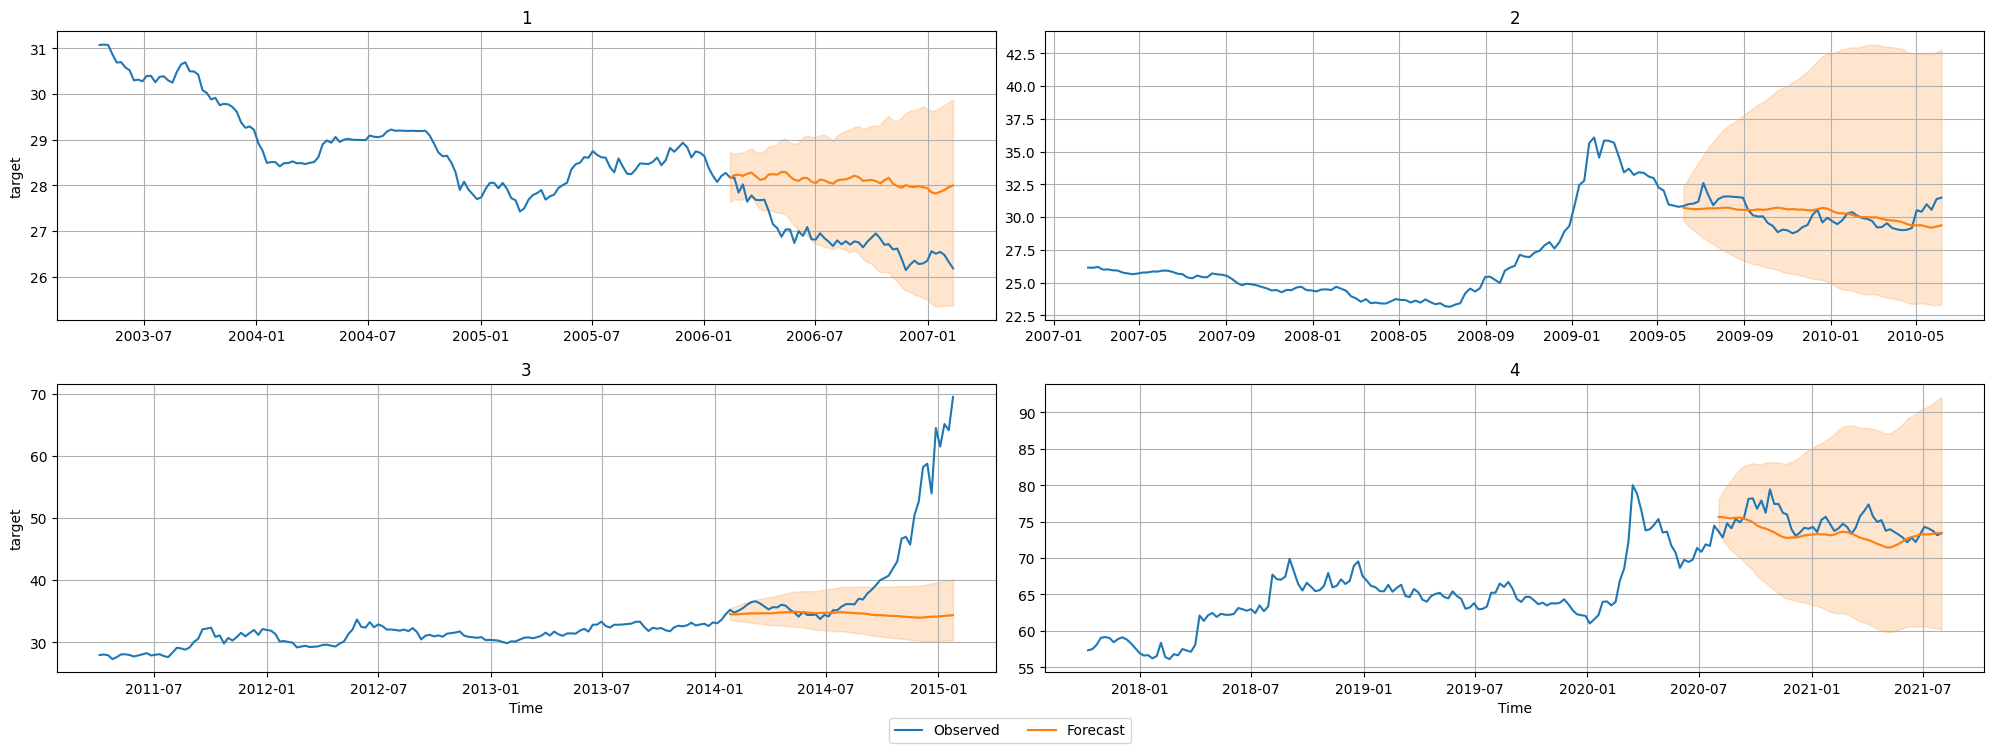

In [72]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:4],
    max_history_length=200,
);

## Fine-tuning

We have seen above how Chronos models can produce forecasts in zero-shot mode. AutoGluon also makes it easy to fine-tune Chronos models on a specific dataset to maximize the predictive accuracy.

The following snippet specifies two settings for the Chronos-Bolt ️(Small) model: zero-shot and fine-tuned. `TimeSeriesPredictor` will perform a lightweight fine-tuning of the pretrained model on the provided training data. We add name suffixes to easily identify the zero-shot and fine-tuned versions of the model.

In [67]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/content/AutogluonModels/ag-20250304_212415'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.53 GB / 12.67 GB (75.2%)
Disk Space Avail:   72.67 GB / 107.72 GB (67.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.


After fitting, we can evaluate the two model variants on the test data and generate a leaderboard.

In [12]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosZeroShot[bolt_small],-0.041446,-0.04172,2.781106,2.042932,0.107625,1


Fine-tuning resulted in a more accurate model, as shown by the better `score_test` on the test set.

Note that all AutoGluon-TimeSeries models report scores in a "higher is better" format, meaning that most forecasting error metrics like WQL are multiplied by -1 when reported.

## Incorporating the covariates

Chronos️ is a univariate model, meaning it relies solely on the historical data of the target time series for making predictions. However, in real-world scenarios, additional exogenous information related to the target series (e.g., holidays, promotions) is often available. Leveraging this information when making predictions can improve forecast accuracy.

Covariates are continuous independent variables (or predictors) in a regression or ANOVA model. These variables can explain some of the variability in the dependent variable. Any measurable variable that has a statistical relationship with the dependent variable qualifies as a covariate.

AG-TS now features covariate regressors that can be combined with univariate models like Chronos-Bolt to incorporate exogenous information.
A `covariate_regressor` in AG-TS is a tabular regression model that is fit on the known covariates and static features to predict the target column at the each time step. The predictions of the covariate regressor are subtracted from the target column, and the univariate model then forecasts the residuals.

In [25]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/grocery_sales/test.csv",
)
data.head()

scaled_price  promotion_email  promotion_homepage  \
item_id  timestamp                                                       
1062_101 2018-01-01      0.879130              0.0                 0.0   
         2018-01-08      0.994517              0.0                 0.0   
         2018-01-15      1.005513              0.0                 0.0   
         2018-01-22      1.000000              0.0                 0.0   
         2018-01-29      0.883309              0.0                 0.0   

                     unit_sales  
item_id  timestamp               
1062_101 2018-01-01       636.0  
         2018-01-08       123.0  
         2018-01-15       391.0  
         2018-01-22       339.0  
         2018-01-29       661.0

We use a grocery sales dataset to demonstrate how Chronos-Bolt can be combined with a covariate regressor. This dataset includes 3 known covariates: `scaled_price`, `promotion_email` and `promotion_homepage` and the task is to forecast the `unit_sales`.

In [26]:
prediction_length = 8
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

The following code fits a TimeSeriesPredictor to forecast `unit_sales` for the next 8 weeks.

Note that we have specified the target column we are interested in forecasting and the names of known covariates while constructing the TimeSeriesPredictor.

We define two configurations for Chronos-Bolt:
- zero-shot configuration that uses only the historical values of `unit_sales` without considering the covariates;
- a configuration with a CatBoost regression model as the `covariate_regressor`. Note that we recommend to apply a `target_scaler` when using a covariate regressor. Target scaler ensures that all time series have comparable scales, often leading to better accuracy.

Like before, we add suffixes to model names to more easily distinguish them in the leaderboard.

In [34]:
train_data

scaled_price  promotion_email  promotion_homepage  \
item_id  timestamp                                                       
1062_101 2018-01-01      0.879130              0.0                 0.0   
         2018-01-08      0.994517              0.0                 0.0   
         2018-01-15      1.005513              0.0                 0.0   
         2018-01-22      1.000000              0.0                 0.0   
         2018-01-29      0.883309              0.0                 0.0   
...                           ...              ...                 ...   
2956_108 2018-05-07      1.000000              0.0                 0.0   
         2018-05-14      1.000000              0.0                 0.0   
         2018-05-21      1.001718              0.0                 0.0   
         2018-05-28      1.001721              0.0                 0.0   
         2018-06-04      1.000000              0.0                 0.0   

                     unit_sales  
item_id  timestamp               
1062_101 2018-01-01       636.0  
         2018-01-08       123.0  
         2018-01-15       391.0  
         2018-01-22       339.0  
         2018-01-29       661.0  
...                         ...  
2956_108 2018-05-07        95.0  
         2018-05-14       202.0  
         2018-05-21       134.0  
         2018-05-28       149.0  
         2018-06-04       108.0  

[7337 rows x 4 columns]

In [36]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="unit_sales",
    known_covariates_names=["scaled_price", "promotion_email", "promotion_homepage"],
).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
    enable_ensemble=False,
    time_limit=60,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/content/AutogluonModels/ag-20250304_210007'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.63 GB / 12.67 GB (75.9%)
Disk Space Avail:   72.67 GB / 107.72 GB (67.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names'

Once the predictor has been fit, we can evaluate it on the test dataset and generate the leaderboard. We see that the model that utilizes the covariates produces a more accurate forecast on the test set.

In [37]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosWithRegressor[bolt_small],-0.268969,-0.358048,2.758152,2.790493,0.836071,2
1,ChronosZeroShot[bolt_small],-0.318562,-0.452296,2.637982,2.313776,0.022441,1


Note that the covariates may not always be useful — for some datasets, the zero-shot model may achieve better accuracy. Therefore, it's always important to try out multiple models and select the one that achieves the best accuracy on held-out data. This is done automatically in AutoGluon's `"high_quality"` and `"best_quality"` presets.